In [1]:
from einops import rearrange
import copy
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from pdb import set_trace
import matplotlib.pyplot as plt
from torch import nn
from x_transformers import  Encoder, Decoder
from x_transformers.autoregressive_wrapper import exists
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from fastai.vision.all import BCEWithLogitsLossFlat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
import os
from timm import create_model
import random
from tqdm import tqdm

In [2]:
class CFG:
    bs = 32
    nw = 4
    model_name = "convnext_large_in22k"
    lr = 1e-4
    wd = 1e-4
    epoch = 10
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_200_BASELINE"
    mixup=False
    exp_name = f"{folder}_{model_name}"

In [3]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df, p, fn):
    pred = torch.sigmoid(p).cpu().numpy().reshape(-1)
    val_df_eval = df.copy()
    val_df_eval["pred"] = pred
    val_df_eval.to_csv(f"{fn}_oof.csv")

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])
    
    tr_comp = val_df_eval.query('data_type=="comp_train"')
    roc_comp_train = roc_auc_score(tr_comp['target'], tr_comp['pred'])
    roc_0_50 = roc_auc_score(
        get_snr(0, 50, val_df_eval)["target"], get_snr(0, 50, val_df_eval)["pred"]
    )
    roc_15_50 = roc_auc_score(
        get_snr(15, 50, val_df_eval)["target"], get_snr(15, 50, val_df_eval)["pred"]
    )
    roc_25_50 = roc_auc_score(
        get_snr(25, 50, val_df_eval)["target"], get_snr(25, 50, val_df_eval)["pred"]
    )
    roc_0_40 = roc_auc_score(
        get_snr(0, 40, val_df_eval)["target"], get_snr(0, 40, val_df_eval)["pred"]
    )

    roc_0_30 = roc_auc_score(
        get_snr(0, 30, val_df_eval)["target"], get_snr(0, 30, val_df_eval)["pred"]
    )

    return {
        "roc_all": roc_100,
        "roc_0_50": roc_0_50,
        "roc_15_50": roc_15_50,
        "roc_25_50": roc_25_50,
        "roc_0_40": roc_0_40,
        "roc_0_30": roc_0_30,
        "roc_comp_train": roc_comp_train
    }

class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(),  torch.sigmoid(p).cpu().numpy().reshape(-1))


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    metric,
    val_df,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    mixup_=False,
    save_md=SaveModel,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    if mixup_:
        mixup = Mixup(num_classes=2, mixup_alpha=0.4, prob=0.8)
        loss_fn_trn = BinaryCrossEntropy()
    mb = master_bar(range(epochs))

    mb.write(
        [
            "epoch",
            "train_loss",
            "valid_loss",
            "val_metric",
            "roc_all",
            "roc_0_50",
            "roc_15_50",
            "roc_25_50",
            "roc_0_40",
            "roc_0_30",
            "roc_comp_train",
        ],
        table=True,
    )
    model.to(device)  # we have to put our model on gpu
    #scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb) in progress_bar(train_dl, parent=mb):
            xb, yb = xb.to(device), yb.to(device)  # putting batches to device
            if mixup_:
                xb, yb = mixup(xb, yb)
           
            out = model(xb)  # forward pass
            loss = loss_fn_trn(out, yb)  # calulation loss

            trn_loss += loss.item()
            #print(loss.item())
            opt.zero_grad()  # zeroing optimizer
            loss.backward()  # backward
            opt.step()  # optimzers step
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        gt = []
        pred = []
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb) in progress_bar(valid_dl, parent=mb):
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out, yb)
                val_loss += loss.item()

                gt.append(yb.detach())
                pred.append(out.detach())
        # calculating metric
        metric_ = metric(torch.cat(pred), torch.cat(gt))
        # saving model if necessary
        save_md(metric_, model, i)
        val_loss /= mb.child.total
        dict_res = generate_report(val_df, torch.cat(pred), f"{folder}/{exp_name}_{i}")

        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
                "metric": [metric_],
                "roc_all": [dict_res["roc_all"]],
                "roc_0_50": [dict_res["roc_0_50"]],
                "roc_15_50": [dict_res["roc_15_50"]],
                "roc_25_50": [dict_res["roc_25_50"]],
                "roc_0_40": [dict_res["roc_0_40"]],
                "roc_0_30": [dict_res["roc_0_30"]],
                "roc_comp_train": [dict_res["roc_comp_train"]]
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
                f"{metric_:.6f}",
                f"{dict_res['roc_all']:.6f}",
                f"{dict_res['roc_0_50']:.6f}",
                f"{dict_res['roc_15_50']:.6f}",
                f"{dict_res['roc_25_50']:.6f}",
                f"{dict_res['roc_0_40']:.6f}",
                f"{dict_res['roc_0_30']:.6f}",
                f"{dict_res['roc_comp_train']:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [4]:
def time_mask(spec, T=10):
    cloned = spec.clone().detach()
    len_spectro = cloned.shape[2]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        cloned[:, :,t_zero:mask_end] = 0
    return cloned




def freq_mask(spec, F=30):
    cloned = spec.clone().detach()
    num_mel_channels = cloned.shape[1]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        cloned[:, f_zero:mask_end, :] = 0
    
    return cloned

In [5]:
def preprocess(sft):
    sft = sft * 1e22
    sft = sft.real**2 + sft.imag**2
    return sft


def normalize(data):
    data[0] = data[0] / data[0].mean()
    data[1] = data[1] / data[1].mean()
    data = data.reshape(2, 360, 128, 32).mean(-1)  # compress 4096 -> 128
    data = data - data.mean()
    data = data / data.std()
    return torch.tensor(data)


def read_h5(file):
    file = Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        k = f[filename]
        h1 = k["H1"]
        l1 = k["L1"]
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        data_dict = {"sft" : np.stack([h1_stft[:, :4096], l1_stft[:, :4096]]), 
                 "timestamps": {"H1": h1_timestamp, 
                                    "L1": l1_timestamp}}
        
        return data_dict
    
class TrainDataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """

    def __init__(self, signal_fns, noise_fns, freq_tfms=False, iteration=50000):
        self.signal_fns = signal_fns
        self.noise_fns = noise_fns
        self.tfms = freq_tfms
        self.iteration = iteration

    def __len__(self):
        return self.iteration

    def __getitem__(self, i):
        noise_fn = random.choice(self.noise_fns)
        signal_fn = random.choice(self.signal_fns)
        if np.random.rand() >= 0.5:
            img = normalize(preprocess(torch.load(noise_fn)["sft"]))
            y = 0.
        else:
            img = normalize(
                preprocess(torch.load(noise_fn)["sft"] + torch.load(signal_fn)["sft"])
            )
            y = 1.
        if self.tfms:
            if np.random.rand() <= 0.7:
                img = freq_mask(img)
            if np.random.rand() <= 0.7:
                img = time_mask(img)
            img = img.numpy()
            if np.random.rand() <= 0.6:  # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.6:  # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.6:  # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            if np.random.rand() <= 0.5:  # channel shuffle
                img = img[np.random.permutation([0, 1]), ...]
        return img, y
    
class ValLoader(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(preprocess(read_h5(r.id)['sft']))
        return img, y



In [6]:
signal = list(Path('../data/custom_data/SIGNAL_V0/data').glob('*.pth'))

real_noise_fns =  sorted(
            Path("../data/custom_data/DATA_V33/data/").glob("*.pth"),
            key=lambda x: str(x).split("_")[-2])

noise = list(Path('../data/custom_data/DATA_V31_V32_NOISE').glob('*.pth')) + real_noise_fns[:1100]

val_df = pd.read_csv('../data/SPLITS/V_22/val_df.csv')
comp_train = pd.read_csv('../data/train_labels.csv')
comp_train.columns = ['fn', 'target']
comp_train = comp_train.query('target>=0')
comp_train['fn'] = comp_train['fn'].apply(lambda x: Path('../data/train')/f'{x}.hdf5')
comp_train.columns = ['id', 'target']
comp_train['data_type'] = 'comp_train'
real_noise_df = pd.DataFrame({"id": real_noise_fns[1100:], 'target': 0., 'snr': 0})
real_noise_df['id'] = real_noise_df['id'].apply(lambda x: Path(str(x).replace('.pth', '.h5')))

val_df = pd.concat([val_df, comp_train, real_noise_df], ignore_index=True)

len(signal), len(noise)

(5769, 10116)

In [7]:
# Train - val split
fold =0
trn_ds = TrainDataset(signal, noise, True)
vld_ds = ValLoader(val_df)

trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)

custom_model = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=1,
                    in_chans=2,
                )

opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = BCEWithLogitsLossFlat()
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    val_df=val_df,
    metric=custom_auc_score,
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}_{fold}",
    device="cuda:0",
    sched=sched,
)

Better model found at epoch 0 with value: 0.8695617507973166.


KeyboardInterrupt: 

In [2]:
alpha = np.random.rand()

(array([292.,  68.,  48.,  47.,  48.,  48.,  54.,  46.,  74., 275.]),
 array([3.56900837e-13, 9.99999998e-02, 2.00000000e-01, 2.99999999e-01,
        3.99999999e-01, 4.99999999e-01, 5.99999999e-01, 6.99999998e-01,
        7.99999998e-01, 8.99999998e-01, 9.99999998e-01]),
 <BarContainer object of 10 artists>)

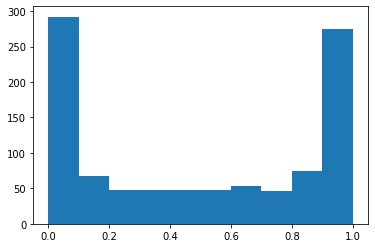

In [3]:
plt.hist([np.random.beta(0.3, 0.3) for i in range(1000)])

(array([178.,  98.,  88.,  62.,  73.,  71.,  71.,  61., 110., 188.]),
 array([2.59786131e-05, 1.00020752e-01, 2.00015525e-01, 3.00010299e-01,
        4.00005072e-01, 4.99999845e-01, 5.99994619e-01, 6.99989392e-01,
        7.99984165e-01, 8.99978939e-01, 9.99973712e-01]),
 <BarContainer object of 10 artists>)

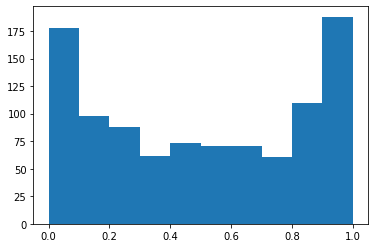

In [4]:
plt.hist([np.random.beta(0.6, 0.6) for i in range(1000)])

(array([236.,  94.,  61.,  57.,  50.,  58.,  59.,  69.,  73., 243.]),
 array([1.76241307e-08, 1.00000012e-01, 2.00000007e-01, 3.00000002e-01,
        3.99999997e-01, 4.99999991e-01, 5.99999986e-01, 6.99999981e-01,
        7.99999976e-01, 8.99999971e-01, 9.99999965e-01]),
 <BarContainer object of 10 artists>)

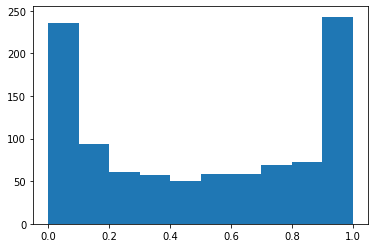

In [5]:
plt.hist([np.random.beta(0.4, 0.4) for i in range(1000)])

(array([195.,  80.,  78.,  64.,  70.,  73.,  62.,  67.,  87., 224.]),
 array([3.64874349e-06, 1.00002877e-01, 2.00002105e-01, 3.00001333e-01,
        4.00000562e-01, 4.99999790e-01, 5.99999018e-01, 6.99998246e-01,
        7.99997474e-01, 8.99996703e-01, 9.99995931e-01]),
 <BarContainer object of 10 artists>)

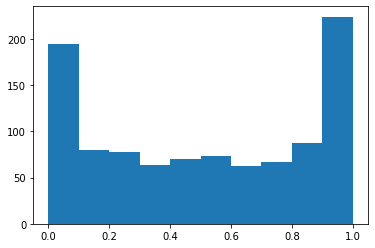

In [6]:
plt.hist([np.random.beta(0.5, 0.5) for i in range(1000)])